In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
import os; print(os.getcwd())
import json

G:\Other computers\My Laptop\UW\Classes\ESS521\project\notebooks


In [3]:
from google.cloud.storage import Client

In [4]:
bucket = Client(project="forest-lst").bucket("forest-lst-tfdata")
spec = json.load(bucket.blob("ca_tree_mort/20_years/1.0.0/features.json").open())
spec = tfds.features.FeatureConnector.from_json(spec).get_tensor_spec()

In [5]:
spec

{'EVI_p5': TensorSpec(shape=(20,), dtype=tf.float32, name=None),
 'EVI_p50': TensorSpec(shape=(20,), dtype=tf.float32, name=None),
 'EVI_p95': TensorSpec(shape=(20,), dtype=tf.float32, name=None),
 'dT_p5': TensorSpec(shape=(20,), dtype=tf.float32, name=None),
 'dT_p50': TensorSpec(shape=(20,), dtype=tf.float32, name=None),
 'dT_p95': TensorSpec(shape=(20,), dtype=tf.float32, name=None),
 'elevation': TensorSpec(shape=(20,), dtype=tf.int64, name=None),
 'latitude': TensorSpec(shape=(20,), dtype=tf.float32, name=None),
 'longitude': TensorSpec(shape=(20,), dtype=tf.float32, name=None),
 'pct_mortality': TensorSpec(shape=(20,), dtype=tf.float32, name=None),
 'prcp': TensorSpec(shape=(20,), dtype=tf.float32, name=None),
 'spei30d_p5': TensorSpec(shape=(20,), dtype=tf.float32, name=None),
 'spei30d_p50': TensorSpec(shape=(20,), dtype=tf.float32, name=None),
 'spei30d_p95': TensorSpec(shape=(20,), dtype=tf.float32, name=None),
 'winter_tmin': TensorSpec(shape=(20,), dtype=tf.float32, name=N

In [6]:
def count_examples_in_dataset(bucket, prefix):
    c = Client()
    info_blob = next(f.name for f in c.list_blobs(bucket, prefix=prefix) if "dataset_info.json" in f.name)
    ds_info = json.load(c.bucket(bucket).blob(info_blob).open())
    return sum(map(int, ds_info["splits"][0]["shardLengths"]))

In [7]:
count_examples_in_dataset("forest-lst-tfdata", "ca_tree_mort/19_years")

3079

In [8]:
import matplotlib.pyplot as plt

years = list(range(2, 21))
data_dirs = ["ca_tree_mort/{}_years".format(y) for y in years]
counts = list(map(lambda x: count_examples_in_dataset("forest-lst-tfdata", x), data_dirs))

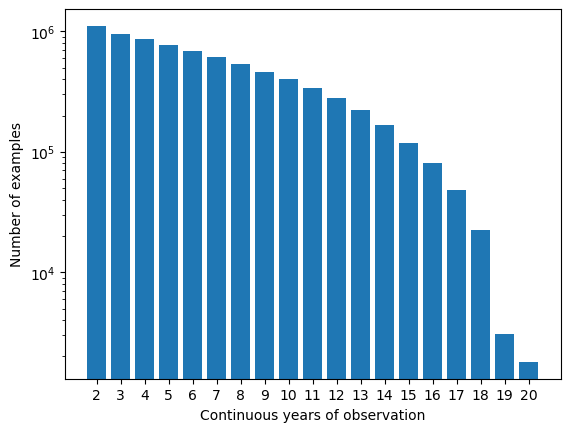

In [9]:
plt.bar(years, counts)
plt.xlabel("Continuous years of observation")
plt.ylabel("Number of examples")
plt.yscale("log")
plt.xticks(years)
plt.show()

In [10]:
tf.io.FixedLenFeature([5], tf.float32)

FixedLenFeature(shape=[5], dtype=tf.float32, default_value=None)

In [11]:
from google.cloud.storage import Client
import json

def read_dataset_gcs(bucket, prefix):
    c = Client()
    # Find all the files in the directory
    files = list(c.bucket(bucket).list_blobs(prefix=prefix))

    # Isolate TFRecords, feature info, dataset info
    records = ["/".join(["gs://{}".format(bucket), f.name]) for f in files if "tfrecord" in f.name]
    feats   = next(f.name for f in files if f.name.endswith("features.json"))
    ds_info = next(f.name for f in files if f.name.endswith("dataset_info.json"))

    # Convert TensorSpec to tf.io.FixedLenFeature
    spec = json.load(c.bucket(bucket).blob(feats).open())
    spec = tfds.features.FeatureConnector.from_json(spec).get_tensor_spec()

    spec_io = {
        key: tf.io.FixedLenFeature([spec[key].shape[0]], spec[key].dtype)
        for key in spec
    }

    # Read all the TFRecords
    ds = tf.data.TFRecordDataset(records)

    # Read dataset information and calculate size
    ds_info = json.load(c.bucket(bucket).blob(ds_info).open())
    ds_size = sum(map(int, ds_info["splits"][0]["shardLengths"]))
    
    return ds, spec_io, ds_size

In [12]:
ds, spec_io, ds_size = read_dataset_gcs("forest-lst-tfdata", "ca_tree_mort/20_years")

In [13]:
ds_size

1801

In [25]:
pct_train, pct_valid, pct_test = 0.70, 0.15, 0.15
n_train = int(ds_size * pct_train)
n_valid = int(ds_size * pct_valid)
n_test  = int(ds_size * pct_test)

ds_train = ds.take(n_train).shuffle(100)
ds_valid = ds.skip(n_train).take(n_valid).shuffle(100)
ds_test  = ds.skip(n_train).skip(n_valid).shuffle(100)

In [26]:
def decoder(proto):
    return tf.io.parse_single_example(proto, spec_io)

def split_input_output(example):
    popped = example.pop("pct_mortality")
    return example, {"pct_mortality": popped}

ds_train = ds_train.map(decoder).map(split_input_output)
ds_valid = ds_valid.map(decoder).map(split_input_output)
ds_test  = ds_test.map(decoder).map(split_input_output)

In [27]:
# Verify that we can read examples
next(iter(ds_train.take(1)))

({'EVI_p5': <tf.Tensor: shape=(20,), dtype=float32, numpy=
  array([0.2084 , 0.2681 , 0.19725, 0.1851 , 0.1656 , 0.1987 , 0.12575,
         0.1913 , 0.2279 , 0.2204 , 0.2013 , 0.1537 , 0.1581 , 0.2274 ,
         0.1734 , 0.2116 , 0.2321 , 0.2072 , 0.16165, 0.1424 ],
        dtype=float32)>,
  'EVI_p50': <tf.Tensor: shape=(20,), dtype=float32, numpy=
  array([0.3898 , 0.3742 , 0.34265, 0.4214 , 0.4351 , 0.3696 , 0.4467 ,
         0.4102 , 0.3824 , 0.4272 , 0.352  , 0.3794 , 0.34415, 0.3676 ,
         0.4052 , 0.321  , 0.3571 , 0.31465, 0.3819 , 0.3305 ],
        dtype=float32)>,
  'EVI_p95': <tf.Tensor: shape=(20,), dtype=float32, numpy=
  array([0.6004 , 0.5804 , 0.58305, 0.6103 , 0.5936 , 0.5784 , 0.58665,
         0.5901 , 0.5979 , 0.5447 , 0.5638 , 0.58   , 0.5625 , 0.5773 ,
         0.6186 , 0.5482 , 0.5131 , 0.5409 , 0.5358 , 0.50725],
        dtype=float32)>,
  'dT_p5': <tf.Tensor: shape=(20,), dtype=float32, numpy=
  array([-6.651621 , -5.3157825, -7.10856  , -6.5847874, -5.7069

In [28]:
import tensorflow.keras as keras

REG = keras.regularizers.L1(0.001)
DROP = 0.05

def build_model(keys, time_series_length):
    # Read all the inputs
    inputs = [
        keras.layers.Input(shape=(time_series_length,), name=key)
        for key in keys if key != "pct_mortality"
    ]

    # Reshape for concatenation
    reshapes = [
        keras.layers.Reshape((time_series_length, 1))(x) for x in inputs
    ]

    # Concatenate everybody together
    concat = keras.layers.Concatenate(axis=2)(reshapes)

    # Normalization
    norm = keras.layers.BatchNormalization(axis=2)(concat)

    # Same architecture as in Rao et al. (2020)
    lstm1 = keras.layers.LSTM(10, dropout=DROP, recurrent_dropout=DROP, bias_regularizer=REG, return_sequences=True)(norm)
    lstm2 = keras.layers.LSTM(10, dropout=DROP, recurrent_dropout=DROP, bias_regularizer=REG, return_sequences=True)(lstm1)
    lstm3 = keras.layers.LSTM(10, dropout=DROP, recurrent_dropout=DROP, bias_regularizer=REG, return_sequences=True)(lstm2)
    lstm4 = keras.layers.LSTM(10, dropout=DROP, recurrent_dropout=DROP, bias_regularizer=REG, return_sequences=False)(lstm3)

    # Using a sigmoid activation function function as a logreg on top of the LSTM units
    out = keras.layers.Dense(1, activation="sigmoid", name="pct_mortality")(lstm4)

    return keras.models.Model(inputs=inputs, outputs=out)

m = build_model(spec_io.keys(), 20)

In [29]:
m.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 EVI_p5 (InputLayer)            [(None, 20)]         0           []                               
                                                                                                  
 EVI_p50 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 EVI_p95 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 dT_p5 (InputLayer)             [(None, 20)]         0           []                               
                                                                                            

In [30]:
m.compile(
    loss="mse",
    optimizer="Nadam"
)

In [31]:
history = m.fit(
    ds_train.batch(64),
    validation_data=ds_valid.batch(64),
    epochs=100,
    verbose=1
)

Epoch 1/100
20/20 [==============================] - 13s 141ms/step - loss: 0.2363 - val_loss: 0.3231
Epoch 2/100
20/20 [==============================] - 2s 88ms/step - loss: 0.1300 - val_loss: 0.3556
Epoch 3/100
20/20 [==============================] - 2s 89ms/step - loss: 0.0867 - val_loss: 0.3623
Epoch 4/100
20/20 [==============================] - 2s 89ms/step - loss: 0.0794 - val_loss: 0.3613
Epoch 5/100
20/20 [==============================] - 2s 91ms/step - loss: 0.0763 - val_loss: 0.3586
Epoch 6/100
20/20 [==============================] - 2s 91ms/step - loss: 0.0741 - val_loss: 0.3562
Epoch 7/100
20/20 [==============================] - 2s 86ms/step - loss: 0.0723 - val_loss: 0.3542
Epoch 8/100
20/20 [==============================] - 2s 89ms/step - loss: 0.0711 - val_loss: 0.3527
Epoch 9/100
20/20 [==============================] - 2s 88ms/step - loss: 0.0699 - val_loss: 0.3515
Epoch 10/100
20/20 [==============================] - 2s 91ms/step - loss: 0.0688 - val_loss: 0.35

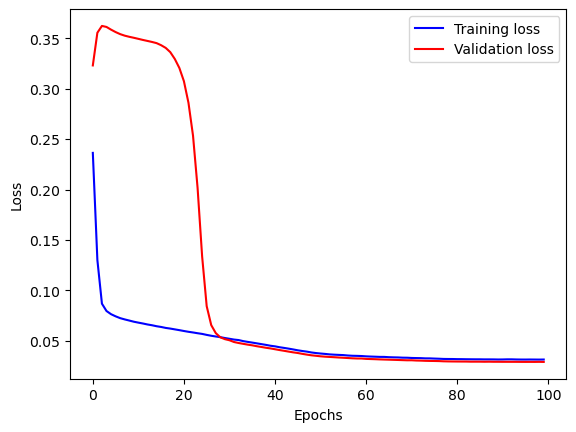

In [34]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, "b", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [49]:
def build_logreg_model(keys, time_series_length):
    # Read all the inputs
    inputs = [
        keras.layers.Input(shape=(time_series_length,), name=key)
        for key in keys if key != "pct_mortality"
    ]

    # Reshape for concatenation
    reshapes = [
        keras.layers.Reshape((time_series_length, 1))(x) for x in inputs
    ]

    # Concatenate everybody together
    concat = keras.layers.Concatenate(axis=2)(reshapes)
    
    # Normalization
    norm = keras.layers.BatchNormalization(axis=2)(concat)

    # Flatten
    flat = keras.layers.Flatten()(norm)

    # Using a sigmoid activation function function as a logreg
    out = keras.layers.Dense(1, activation="sigmoid", name="pct_mortality", kernel_initializer="zeros")(flat)

    return keras.models.Model(inputs=inputs, outputs=out)

m_logreg = build_logreg_model(spec_io.keys(), 20)

In [40]:
m_logreg.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 EVI_p5 (InputLayer)            [(None, 20)]         0           []                               
                                                                                                  
 EVI_p50 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 EVI_p95 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 dT_p5 (InputLayer)             [(None, 20)]         0           []                               
                                                                                            

In [41]:
m_logreg.compile(
    loss="mse",
    optimizer="Nadam"
)

In [42]:
history_logreg = m_logreg.fit(
    ds_train.batch(64),
    validation_data=ds_valid.batch(64),
    epochs=100,
    verbose=1
)

Epoch 1/100
20/20 [==============================] - 3s 37ms/step - loss: 0.2281 - val_loss: 0.9233
Epoch 2/100
20/20 [==============================] - 1s 25ms/step - loss: 0.0816 - val_loss: 0.9233
Epoch 3/100
20/20 [==============================] - 1s 24ms/step - loss: 0.0480 - val_loss: 0.9233
Epoch 4/100
20/20 [==============================] - 1s 23ms/step - loss: 0.0401 - val_loss: 0.9233
Epoch 5/100
20/20 [==============================] - 1s 25ms/step - loss: 0.0373 - val_loss: 0.9233
Epoch 6/100
20/20 [==============================] - 1s 27ms/step - loss: 0.0359 - val_loss: 0.9233
Epoch 7/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0350 - val_loss: 0.9233
Epoch 8/100
20/20 [==============================] - 1s 24ms/step - loss: 0.0344 - val_loss: 0.9233
Epoch 9/100
20/20 [==============================] - 1s 26ms/step - loss: 0.0341 - val_loss: 0.9233
Epoch 10/100
20/20 [==============================] - 1s 25ms/step - loss: 0.0339 - val_loss: 0.9233

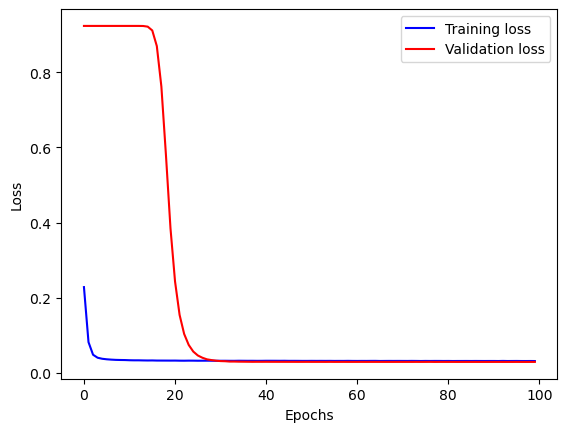

In [43]:
loss = history_logreg.history["loss"]
val_loss = history_logreg.history["val_loss"]
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, "b", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [68]:
# What is the baseline loss if we assume no mortality ever?
import numpy as np
y_valid = np.array([example[1]["pct_mortality"][-1].numpy() for example in ds_valid.take(n_valid)])
y_guess = np.ones_like(y_valid) + np.mean(y_valid)

In [69]:
keras.losses.mean_squared_error(y_valid, y_guess)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0165893>

In [76]:
y_guess_lstm = m.predict(ds_valid.batch(64))

5/5 [==============================] - 1s 19ms/step


In [74]:
y_guess

array([1.0450015, 1.0450015, 1.0450015, 1.0450015, 1.0450015, 1.0450015,
       1.0450015, 1.0450015, 1.0450015, 1.0450015, 1.0450015, 1.0450015,
       1.0450015, 1.0450015, 1.0450015, 1.0450015, 1.0450015, 1.0450015,
       1.0450015, 1.0450015, 1.0450015, 1.0450015, 1.0450015, 1.0450015,
       1.0450015, 1.0450015, 1.0450015, 1.0450015, 1.0450015, 1.0450015,
       1.0450015, 1.0450015, 1.0450015, 1.0450015, 1.0450015, 1.0450015,
       1.0450015, 1.0450015, 1.0450015, 1.0450015, 1.0450015, 1.0450015,
       1.0450015, 1.0450015, 1.0450015, 1.0450015, 1.0450015, 1.0450015,
       1.0450015, 1.0450015, 1.0450015, 1.0450015, 1.0450015, 1.0450015,
       1.0450015, 1.0450015, 1.0450015, 1.0450015, 1.0450015, 1.0450015,
       1.0450015, 1.0450015, 1.0450015, 1.0450015, 1.0450015, 1.0450015,
       1.0450015, 1.0450015, 1.0450015, 1.0450015, 1.0450015, 1.0450015,
       1.0450015, 1.0450015, 1.0450015, 1.0450015, 1.0450015, 1.0450015,
       1.0450015, 1.0450015, 1.0450015, 1.0450015, 